Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `/media/labfiles/nsom/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics

In [4]:
## from Igor Vurgaftman, Matthew P. Lumb, and Jerry R. Meyer, Bands and Photons in III-V Semiconductor Quantum Structures,Oxford, 2020 chapter 3
model=["E_g+c*(1+2*F)*(k_x^2+k_y^2+k_z^2)+VBO" "0+im(cp*k_x*E_p)" "0+im(cp*k_y*E_p)" "0+im(cp*k_z*E_p)" "0" "0" "0" "0";
    "0+im(-cp*k_x*E_p)" "VBO-L*k_x^2-M*(k_y^2+k_z^2)" "-N*k_x*k_y" "-N*k_x*k_z" "0" "0" "0" "0";
    "0+im(-cp*k_y*E_p)" "-N*k_x*k_y" "VBO-L*k_y^2-M*(k_x^2+k_z^2)" "-N*k_y*k_z" "0" "0" "0" "0";
    "0+im(-cp*k_z*E_p)" "-N*k_x*k_z" "-N*k_y*k_z" "VBO-L*k_z^2-M*(k_y^2+k_x^2)" "0" "0" "0" "0";
    "0" "0" "0" "0" "E_g+c*(1+2*F)*(k_x^2+k_y^2+k_z^2)+VBO" "0+im(cp*k_x*E_p)" "0+im(cp*k_y*E_p)" "0+im(cp*k_z*E_p)" ;
    "0" "0" "0" "0" "0+im(-cp*k_x*E_p)" "VBO-L*k_x^2-M*(k_y^2+k_z^2)" "-N*k_x*k_y" "-N*k_x*k_z";
    "0" "0" "0" "0" "0+im(-cp*k_y*E_p)" "-N*k_x*k_y" "VBO-L*k_y^2-M*(k_x^2+k_z^2)" "-N*k_y*k_z";
    "0" "0" "0" "0" "0+im(-cp*k_z*E_p)" "-N*k_x*k_z" "-N*k_y*k_z" "VBO-L*k_z^2-M*(k_y^2+k_x^2)";];

strK=["k_x","k_y","k_z"];

HsT= KPpack.createSymbMatrix(model);

Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(HsT);
#real(HsT)

In [5]:
HstrSOC=["0" "0" "0" "0" "0" "0" "0" "0";
        "0" "0" "0+i*(-d/3)" "0" "0" "0" "0" "d/3";
        "0" "0+i*(d/3)" "0" "0" "0" "0" "0" "0+i*(-d/3)";
        "0" "0" "0" "0" "0" "-d/3" "0+i*(d/3)" "0";
        "0" "0" "0" "0" "0" "0" "0" "0";
        "0" "0" "0" "-d/3" "0" "0" "0+i*(d/3)" "0";
        "0" "0" "0" "0+i*(-d/3)" "0" "0+i*(-d/3)" "0" "0";
        "0" "d/3" "0+i*(d/3)" "0" "0" "0" "0" "0";];
dvar=KPpack.StrtoSymbConv("Δ")
HSOC= KPpack.createSymbMatrix(HstrSOC); HSVar= KPpack.getVar(HSOC);
HSocRe=substitute(real(HSOC),Dict(HSVar[1]=>dvar)); HSocIm=substitute(imag(HSOC),Dict(HSVar[1]=>dvar))
HSOC=HSocRe+im*HSocIm;

In [6]:
L="c*(g_1+4*g_2-(E_p/E_g))"; L=KPpack.StrtoSymbConv(L);
M="c*(g_1-2*g_2)"; M=KPpack.StrtoSymbConv(M)
N="c*(6*g_3-(E_p/E_g))"; N=KPpack.StrtoSymbConv(N)
#D="c*(1+2*F+(E_p/E_g))"; D=KPpack.StrtoSymbConv(D)
#Ac="L+c*(E_p/E_g)"; Ac=KPpack.StrtoSymbConv(Ac); AcVar=Symbolics.get_variables(Ac);Ac=substitute(Ac,Dict(AcVar[1]=>L))
#Cc="N+c*(E_p/E_g)"; Cc=KPpack.StrtoSymbConv(Cc); CcVar=Symbolics.get_variables(Cc);Cc=substitute(Cc,Dict(CcVar[1]=>N));

In [7]:
Hre=real(HsT); Him=imag(HsT) 
#Hre=substitute(Hre,Dict(HVar[3]=>D)); Him=substitute(Him,Dict(HVar[3]=>D)); 
#Hre=substitute(Hre,Dict(HVar[7]=>Ac)); Him=substitute(Him,Dict(HVar[7]=>Ac)); 
Hre=substitute(Hre,Dict(HVar[8]=>L)); Him=substitute(Him,Dict(HVar[8]=>L));
Hre=substitute(Hre,Dict(HVar[9]=>M)); Him=substitute(Him,Dict(HVar[9]=>M));
Hre=substitute(Hre,Dict(HVar[10]=>N)); Him=substitute(Him,Dict(HVar[10]=>N));
#Hre=substitute(Hre,Dict(HVar[9]=>Cc)); Him=substitute(Him,Dict(HVar[9]=>Cc)); 

In [8]:
H8x8=Hre+im*Him;
Htot=H8x8+HSOC;

In [9]:
real(Htot)
#HVar

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                   (1//3)*Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [10]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);


In [11]:
imag(H0)

8×8 Matrix{Num}:
 0                    E_p*cp*k_x  …         0                    0
 -E_p*cp*k_x         0                      0                    0
 -E_p*cp*k_y  (1//3)*Δ                      0            (-1//3)*Δ
 0                   0               (1//3)*Δ                    0
 0                   0                       E_p*cp*k_y          0
 0                   0            …  (1//3)*Δ                    0
 0                   0                      0                    0
 0                   0                      0                    0

## test the bulk calculation

In [12]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1.519

In [13]:
kmax= 1.4; Nt=100; consth=0.038; const2=0.19
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

# Plot band diagram

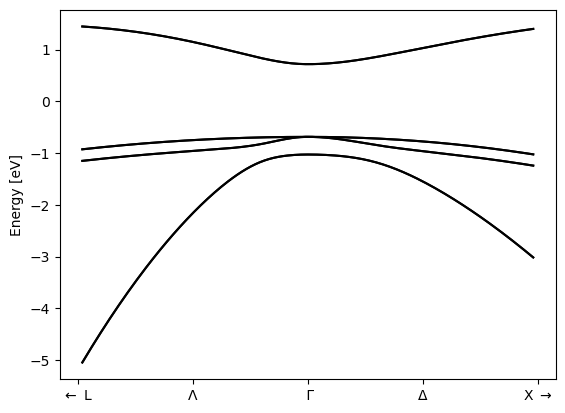

In [14]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

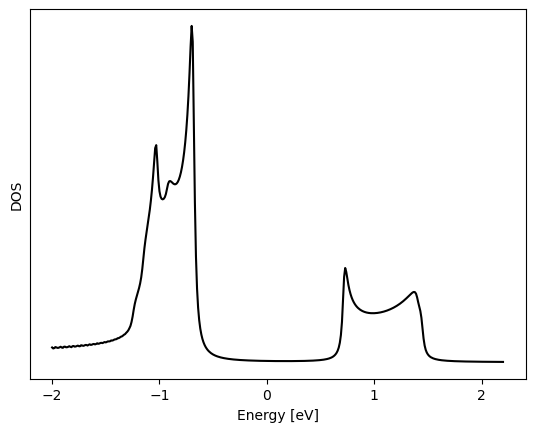

In [15]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [16]:
nlayer=7; Npts=100
layer=Array{KPpack.mat}(undef,nlayer)

layer[1]=KPpack.mat("GaAs",30);
layer[2]=KPpack.mat("AlGaAs_0.2",70);
layer[3]=KPpack.mat("GaAs",5);
layer[4]=KPpack.mat("AlGaAs_0.2",3);
layer[5]=KPpack.mat("GaAs",7);
layer[6]=KPpack.mat("AlGaAs_0.2",70);
layer[7]=KPpack.mat("GaAs",30);


X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);

# Plot structure

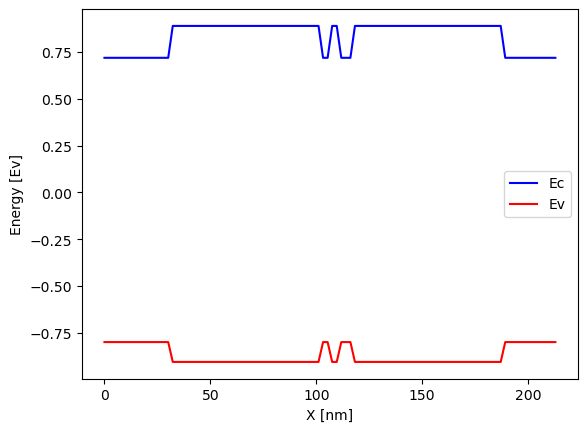

In [17]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

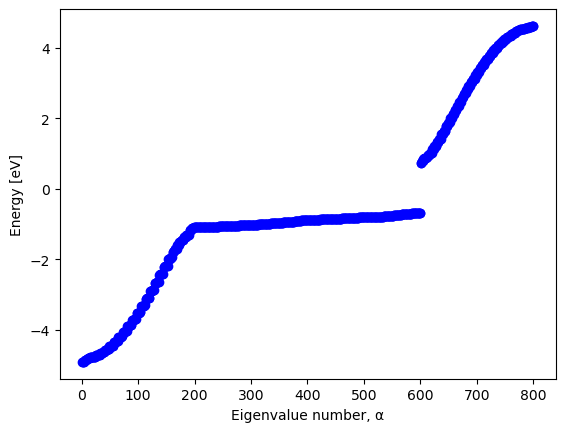

  6.410819 seconds (7.61 M allocations: 499.351 MiB, 3.04% gc time, 69.98% compilation time)


In [18]:
c=0.038; cps=1.0; dx=X[2]-X[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1,H2,c,cps,dx,Emomentum);
KPpack.PloteigvQW(Npts,Eqw0);

GaAs# QW Band Structure Calculation

In [19]:
kmax= 0.1; Nt=50;
n=10
sV,sC=KPpack.eigenValQW(real(Eqw0))

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1,H2,n,c,cps,sV,sC,Emomentum);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1,H2,n,c,cps,sV,sC,Emomentum);

  9.923351 seconds (9.56 M allocations: 2.120 GiB, 3.78% gc time, 46.95% compilation time)
  4.545039 seconds (2.46 M allocations: 1.642 GiB, 4.19% gc time)


## Valence Band 

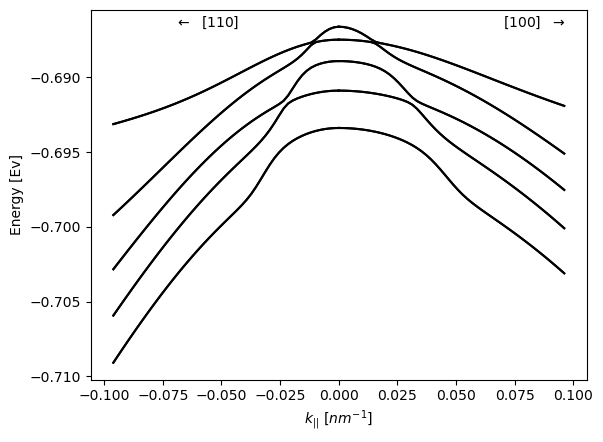

In [20]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

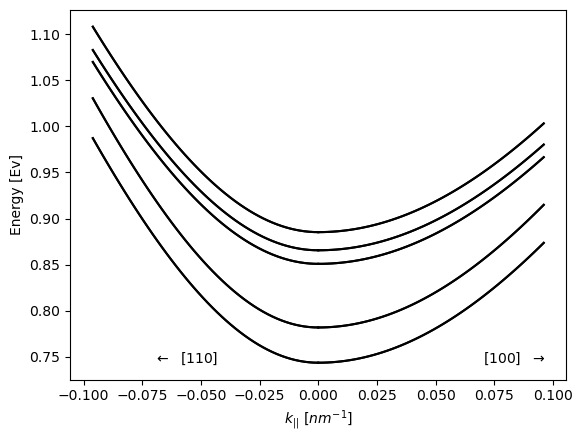

In [21]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

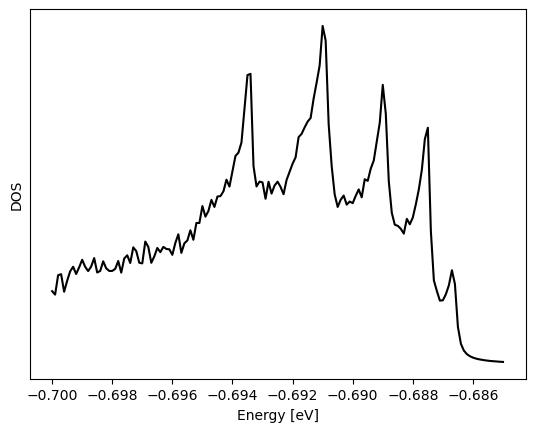

In [22]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.7,-0.685,0.0001,Evqw,2e-4);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

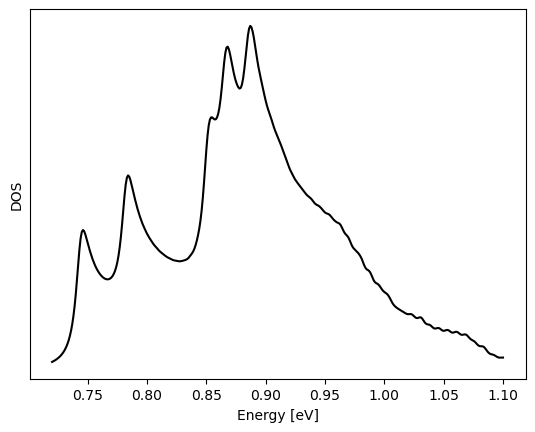

In [23]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.72,1.1,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

save a file with band structure

In [24]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# ====================================================================================

In [25]:
A,B,C=KPpack.constructMatrixFD(H0,H1,H2);
exclude=["k_x","k_y","k_z","c","cp"]; b1="r"; b2="l"
excS=KPpack.setExcludePar(exclude)
PrH=KPpack.getVar(Htot)
Al,Ar,Bl,Br,Cr,Cl=KPpack.createBmatrizFD(H0,H1,H2,PrH,excS,b1,b2);


In [26]:
mt=real(H2)

8×8 Matrix{Num}:
 c*(1 + 2F)*(k_x^2 + k_y^2) - c*(1 + 2F)*(1 + k_x^2 + k_y^2)  …       0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                     …       0
        0                                                             0
        0                                                        -((c*(E_p - E_g*g_1 - 4E_g*g_2)) / E_g)

In [27]:
simplify(mt[2,2])

c*(1 + k_y^2)*(g_1 - 2g_2) - c*(g_1 - 2g_2)*(k_y^2)

In [28]:
imag(Htot)

8×8 Matrix{Num}:
 0                    E_p*cp*k_x           E_p*cp*k_y  …          0
 -E_p*cp*k_x         0            (-1//3)*Δ                       0
 -E_p*cp*k_y  (1//3)*Δ                    0               (-1//3)*Δ
 -E_p*cp*k_z         0                    0                       0
 0                   0                    0                        E_p*cp*k_z
 0                   0                    0            …          0
 0                   0                    0                       0
 0                   0             (1//3)*Δ                       0